## Импорты

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import csv
try:
    from PIL import Image
except ImportError:
    import Image
# from skimage.feature import match_template

## Обработка изображения и поиск секторов

In [6]:
image=cv2.imread('тест2.jpg')


In [4]:
image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

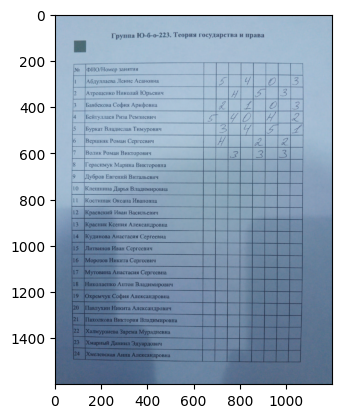

In [7]:
plotting = plt.imshow(image)
plt.show()

От кода в 4 блоках ниже я отказался, пусть пользователь сам указывает ориентацию изображения

In [29]:
gray_image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
gray_template = template[:,:,0]
#gray_template = np.ones((35, 35))
plotting = plt.imshow(gray_template,cmap='gray')
plt.show()

gray_template

NameError: name 'template' is not defined

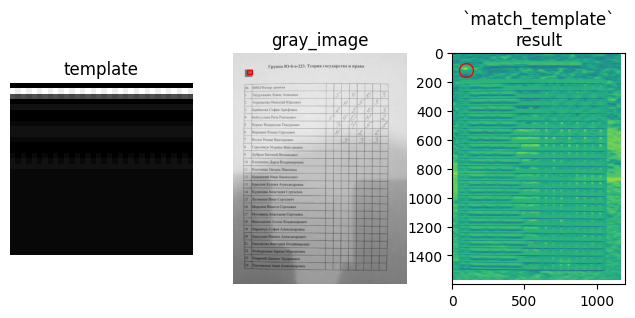

In [143]:
result = match_template(gray_image, gray_template)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

ax1.imshow(gray_template, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(gray_image, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('gray_image')
# highlight matched region
hgray_template, wgray_template = gray_template.shape
rect = plt.Rectangle((x, y), wgray_template, hgray_template, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

In [105]:
x, y

(97, 112)

Продолжаем преобразования

In [8]:
image = cv2.fastNlMeansDenoising(image)
gray_scale=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
img_bin = cv2.adaptiveThreshold(gray_scale, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                          cv2.THRESH_BINARY_INV, 199, 5)
gray_scale

array([[188, 188, 188, ..., 188, 188, 188],
       [188, 188, 188, ..., 188, 188, 188],
       [188, 188, 188, ..., 188, 188, 188],
       ...,
       [104, 104, 105, ..., 113, 114, 114],
       [104, 104, 104, ..., 113, 114, 114],
       [105, 104, 104, ..., 115, 115, 114]], dtype=uint8)

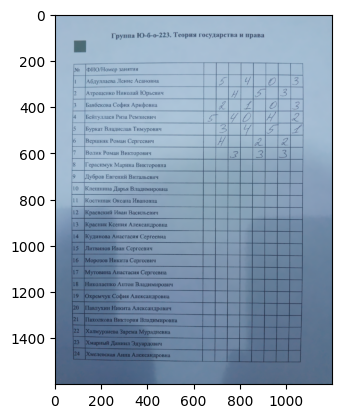

In [9]:
plotting = plt.imshow(image)
plt.show()

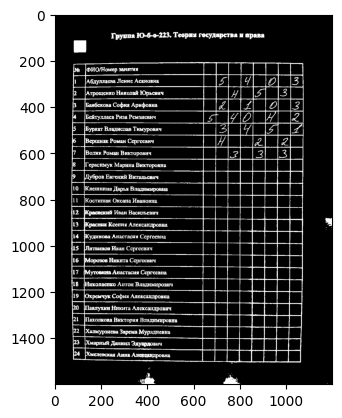

In [10]:
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

In [11]:
# Размер линий подобран эмпирически в соответствии с задачей
kernal_h = np.ones((1,60), np.uint8)
kernal_v = np.ones((60,1), np.uint8)

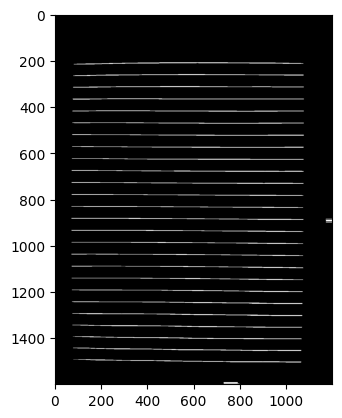

In [12]:
img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
plotting = plt.imshow(img_bin_h,cmap='gray')
plt.show()

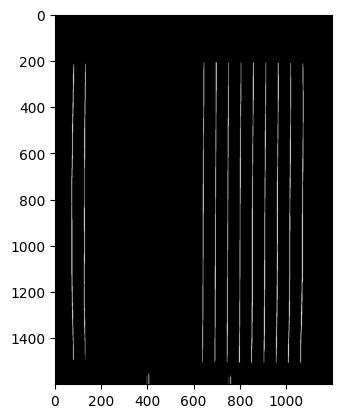

In [13]:
img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)
plotting = plt.imshow(img_bin_v,cmap='gray')
plt.show()

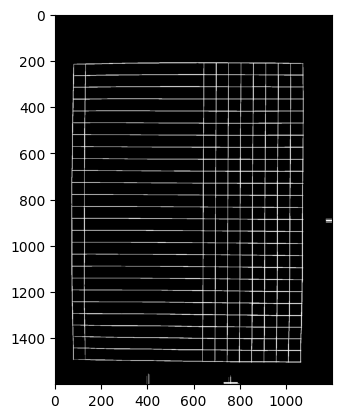

In [14]:
img_bin_final=img_bin_h|img_bin_v
plotting = plt.imshow(img_bin_final,cmap='gray')
plt.show()

In [15]:
num_labels , labels, stats, centroids  = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)

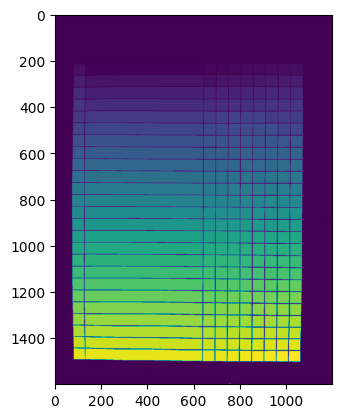

In [16]:
plotting = plt.imshow(labels)
plt.show()


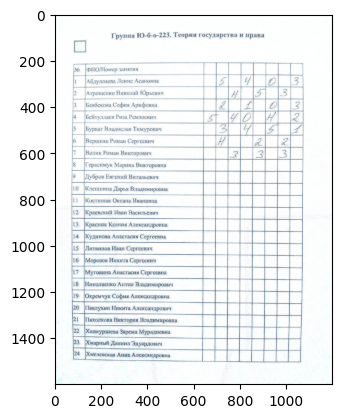

In [17]:
# Создание очищенного изображения
se=cv2.getStructuringElement(cv2.MORPH_RECT , (8,8))
bg=cv2.morphologyEx(image, cv2.MORPH_DILATE, se)
clean_image=cv2.divide(image, bg, scale=255)
plotting = plt.imshow(clean_image)
plt.show()


In [18]:
# Высчитываем среднюю площадь ячейки и удаляем ошибочно выделенные
# сектора и внешние рамки
mean_area = np.mean(stats[2:,4], axis=0)
arr = np.delete(
    stats, np.where(
        (stats[:, 4] < (mean_area // 10)) | (stats[:, 4] > (mean_area * 10))
    )[0],
    axis=0
)
arr.shape

(250, 5)

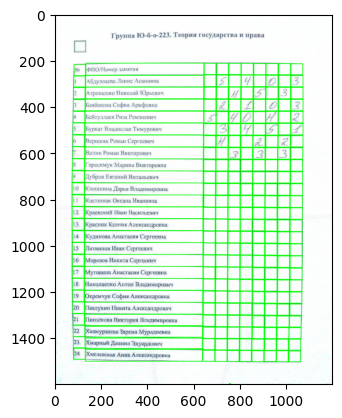

In [19]:
# Наложение сетки на очищенное изображения
clean_image_with_table = clean_image.copy()
for x,y,w,h,area in stats[2:]:
    cv2.rectangle(clean_image_with_table,(x,y),(x+w,y+h),(0,255,0),2)
plotting = plt.imshow(clean_image_with_table)
plt.show()

In [20]:
# Вычисляем среднюю высоту ячейки и создаем новый отсортированный список
mean_hight = np.mean(arr[:,3], axis=0)

new_arr = [[list(arr[0])]]

for cell in arr[1:]:
    y = cell[1]
    row_find = False
    for row in new_arr:
        first_cell_y = row[0][1]
        if abs(y-first_cell_y) < mean_hight / 2:
            row.append(list(cell))
            row_find = True
    if not row_find:
        new_arr.append([list(cell)])
        
sorted_arr = sorted(new_arr, key=lambda x: x[0][1])
for row in sorted_arr:
    row.sort()
df = pd.DataFrame(sorted_arr)
df

,0,1,2,3,4,5,6,7,8,9
0,"[82, 218, 49, 48, 2291]","[133, 212, 509, 53, 23972]","[644, 213, 50, 48, 2396]","[698, 213, 50, 48, 2400]","[750, 213, 52, 48, 2496]","[804, 213, 51, 49, 2467]","[858, 214, 51, 48, 2448]","[911, 214, 51, 48, 2448]","[965, 214, 51, 48, 2415]","[1018, 215, 51, 47, 2397]"
1,"[81, 268, 49, 47, 2254]","[132, 264, 509, 51, 24439]","[644, 263, 50, 50, 2451]","[698, 264, 50, 50, 2448]","[750, 264, 52, 50, 2587]","[804, 264, 51, 50, 2501]","[858, 264, 51, 49, 2462]","[911, 265, 51, 49, 2479]","[966, 265, 50, 49, 2423]","[1018, 266, 52, 48, 2417]"
2,"[80, 318, 49, 48, 2337]","[132, 316, 509, 50, 25053]","[644, 316, 50, 50, 2500]","[697, 316, 50, 50, 2483]","[750, 316, 51, 50, 2550]","[804, 316, 50, 50, 2500]","[858, 316, 50, 50, 2500]","[911, 316, 51, 50, 2525]","[966, 317, 50, 49, 2450]","[1019, 317, 51, 49, 2499]"
3,"[79, 370, 50, 48, 2319]","[131, 368, 510, 50, 24981]","[643, 369, 51, 49, 2468]","[697, 369, 50, 49, 2450]","[750, 369, 51, 50, 2483]","[803, 369, 51, 50, 2539]","[857, 369, 51, 50, 2498]","[910, 369, 52, 49, 2522]","[965, 369, 51, 49, 2497]","[1018, 369, 52, 49, 2506]"
4,"[78, 421, 50, 48, 2358]","[130, 420, 511, 50, 25035]","[643, 421, 51, 50, 2517]","[696, 422, 51, 49, 2474]","[750, 422, 50, 49, 2450]","[802, 422, 52, 49, 2526]","[856, 422, 52, 49, 2471]","[910, 421, 52, 49, 2497]","[964, 421, 52, 49, 2544]","[1018, 421, 52, 49, 2548]"
5,"[77, 471, 50, 49, 2338]","[130, 471, 510, 51, 25176]","[642, 474, 52, 49, 2438]","[696, 474, 50, 49, 2450]","[749, 474, 51, 49, 2460]","[802, 474, 52, 49, 2510]","[856, 474, 51, 49, 2482]","[910, 474, 52, 49, 2460]","[964, 473, 52, 49, 2490]","[1018, 473, 52, 49, 2548]"
6,"[77, 523, 49, 49, 2401]","[130, 523, 510, 51, 25250]","[642, 526, 51, 48, 2448]","[696, 526, 50, 49, 2433]","[749, 526, 50, 49, 2450]","[802, 526, 51, 49, 2485]","[855, 526, 51, 49, 2496]","[910, 526, 51, 49, 2485]","[963, 526, 52, 49, 2477]","[1018, 526, 52, 48, 2459]"
7,"[77, 574, 50, 50, 2440]","[130, 575, 510, 51, 25056]","[642, 578, 51, 48, 2448]","[695, 578, 51, 48, 2434]","[748, 578, 51, 48, 2399]","[802, 578, 50, 49, 2409]","[855, 578, 51, 49, 2499]","[909, 578, 51, 49, 2497]","[962, 578, 52, 49, 2509]","[1018, 578, 51, 49, 2498]"
8,"[75, 626, 51, 49, 2453]","[128, 626, 511, 52, 24872]","[642, 630, 51, 48, 2432]","[695, 630, 51, 48, 2446]","[748, 630, 50, 48, 2400]","[802, 630, 50, 48, 2400]","[854, 630, 52, 48, 2476]","[908, 630, 52, 48, 2434]","[962, 630, 52, 49, 2521]","[1017, 630, 51, 49, 2431]"
9,"[74, 678, 52, 49, 2518]","[128, 678, 511, 52, 25117]","[642, 681, 50, 49, 2450]","[695, 681, 50, 49, 2440]","[748, 682, 50, 48, 2400]","[802, 682, 50, 48, 2372]","[854, 682, 52, 49, 2481]","[908, 682, 51, 48, 2439]","[962, 682, 52, 48, 2475]","[1017, 682, 51, 49, 2489]"


[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [255   0   0 ...   0   0   0]
 [255   0   0 ...   0   0   0]]


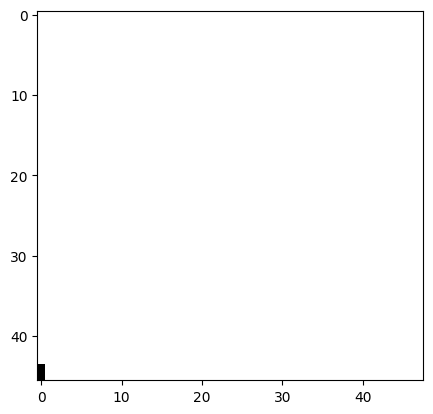

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


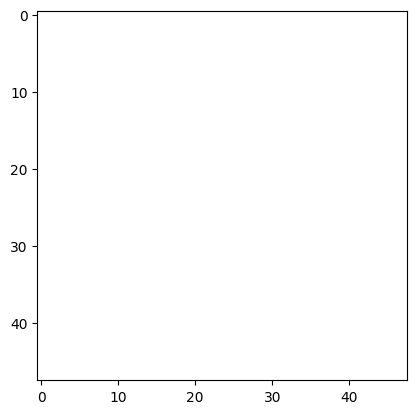

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


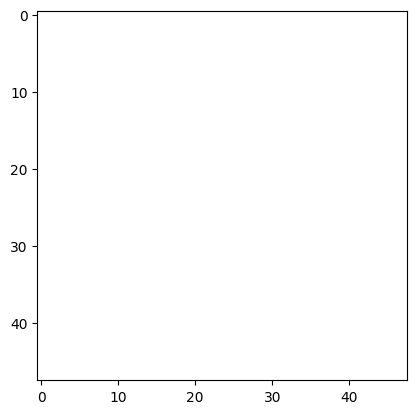

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


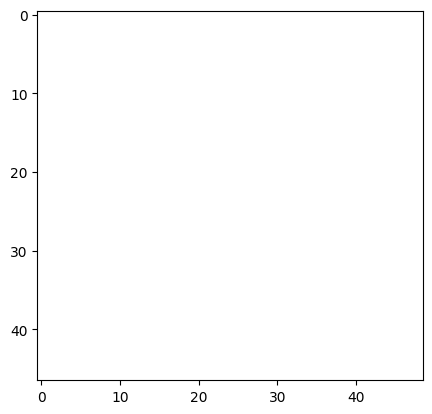

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


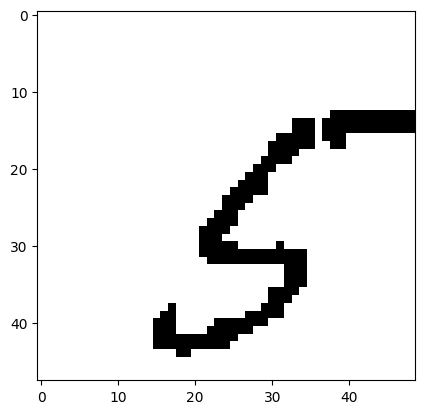

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


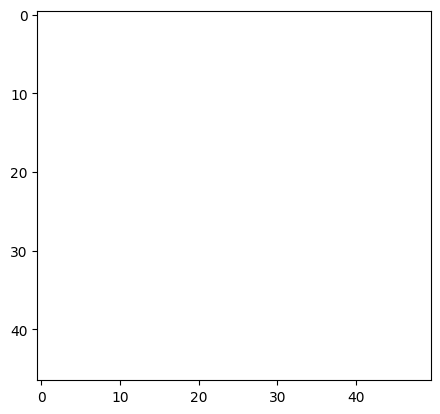

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


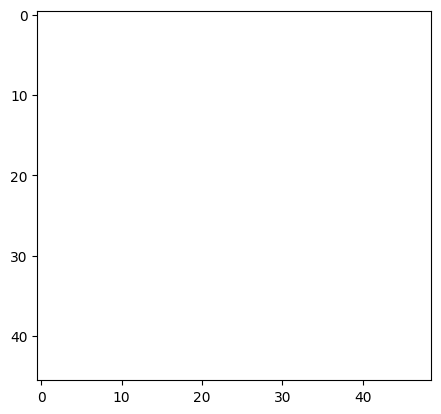

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


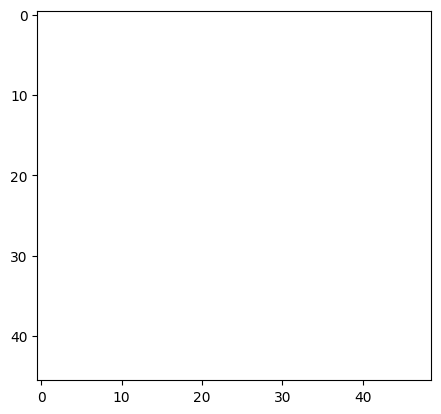

[[  0 255   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


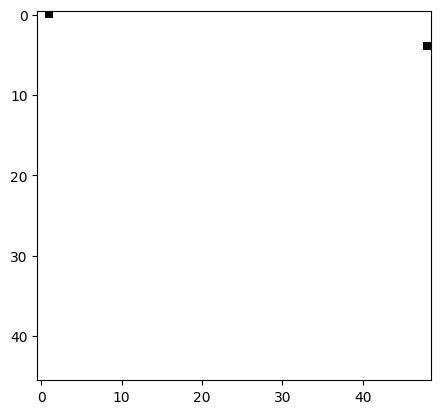

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


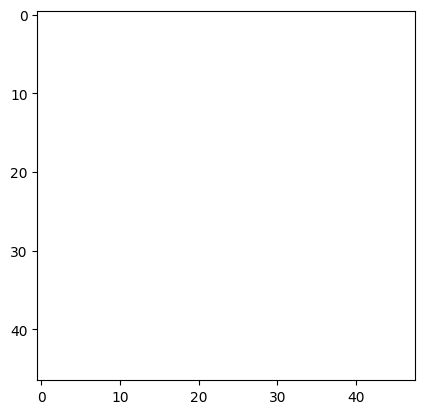

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


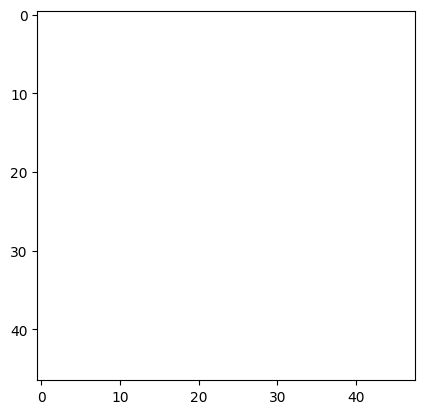

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


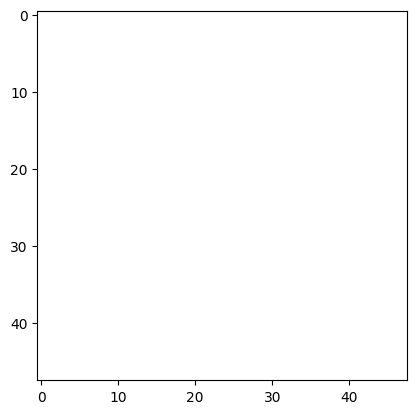

[[  0   0   0 ...   0 255   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 255]
 [  0   0   0 ...   0   0   0]]


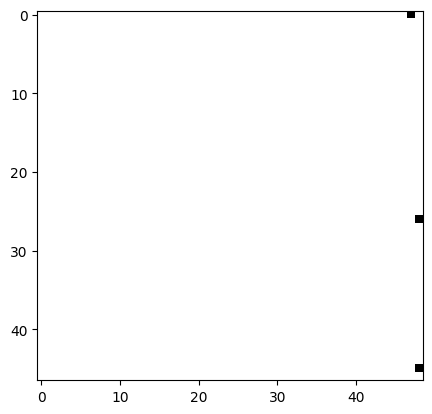

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


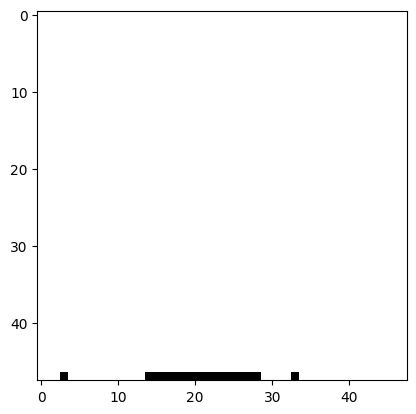

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


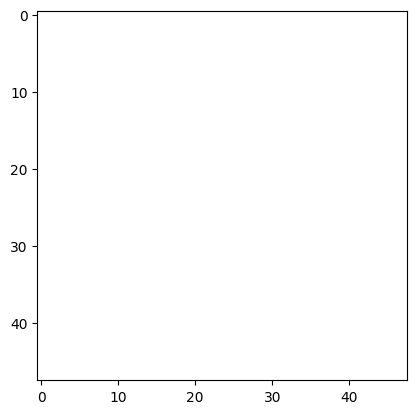

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [255 255   0 ...   0   0   0]]


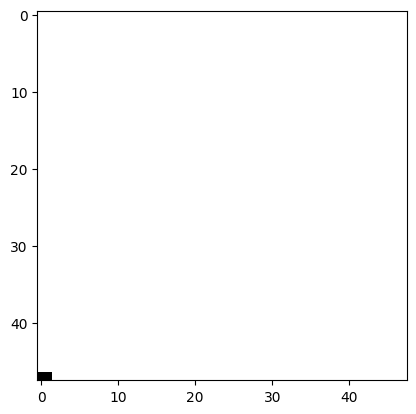

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0 255   0]]


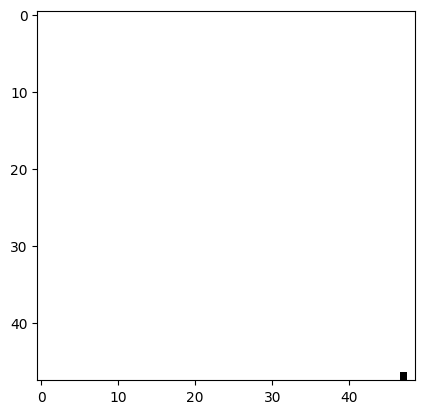

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


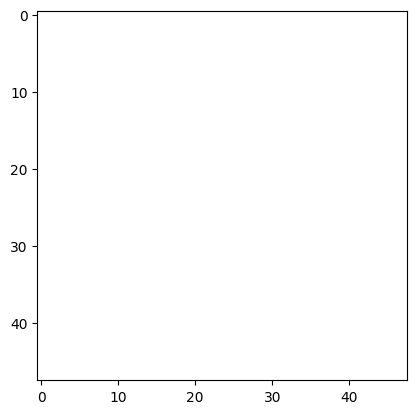

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


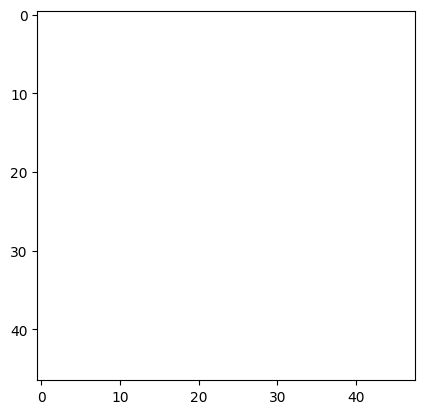

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


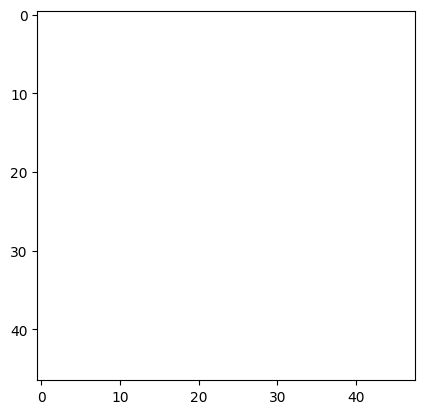

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


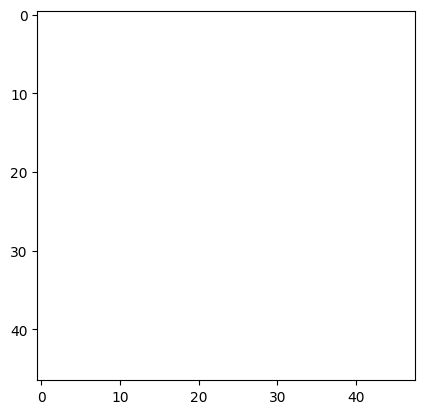

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


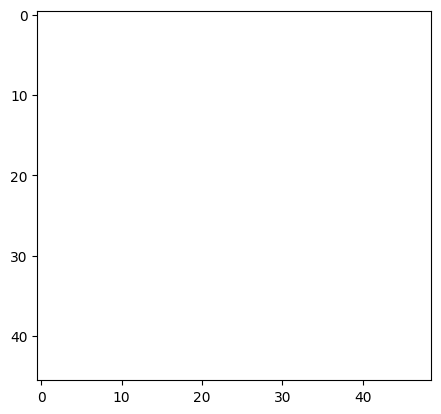

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


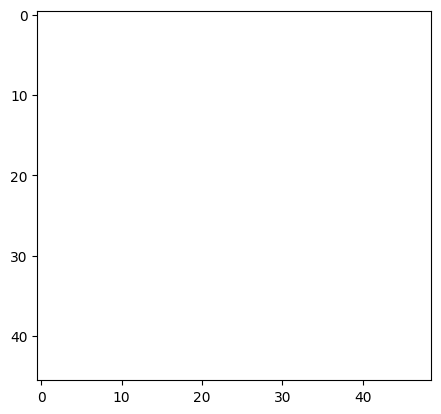

[[  0   0   0 ...   0   0 255]
 [255   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


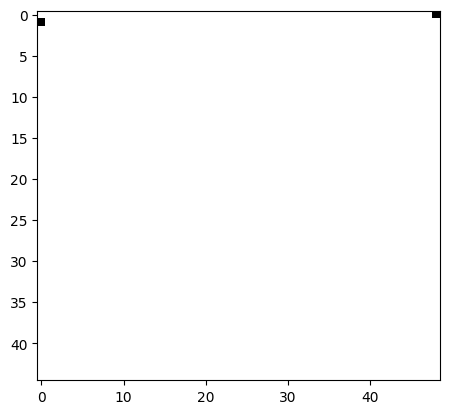

[[  0 255 255 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


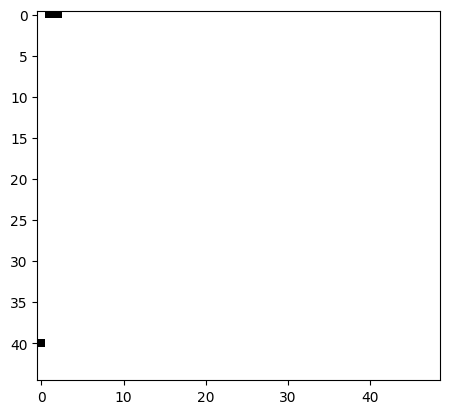

In [22]:

for index, row in df.iterrows():
    for cell in range(len(row)):
        if cell == 2:
            cell = row[cell]
            cell = img_bin[cell[1]+1:cell[1]+cell[3]-1, cell[0]+1:cell[0]+cell[2]-1]
            print(cell)
            plotting = plt.imshow(cell,cmap='gray_r', )
            plt.show()
        

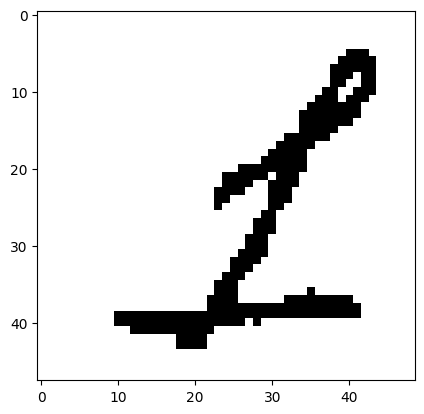

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [24]:
# Проверяем, что ячейки верно отсортированы
cell = sorted_arr[3][5]
cell[1]
cell = img_bin[cell[1]+1:cell[1]+cell[3]-1, cell[0]+1:cell[0]+cell[2]-1]
plotting = plt.imshow(cell,cmap='gray_r', )
plt.show()
print(cell)

In [76]:
import json


js = json.dumps(np.ndarray.tolist(cell))
js

'[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

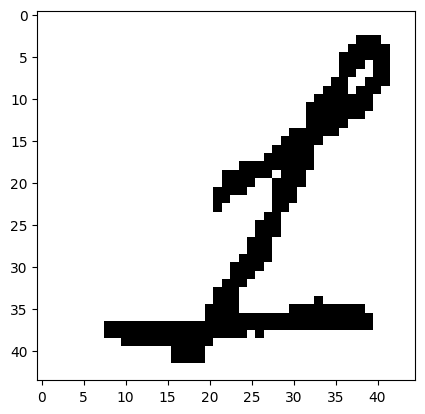

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 255 255 255   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 255 255 255 255 255   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

In [49]:
cell_copy = sorted_arr[3][5]
cell_copy = img_bin[cell_copy[1]+3:cell_copy[1]+cell_copy[3]-3, cell_copy[0]+3:cell_copy[0]+cell_copy[2]-3]
plotting = plt.imshow(cell_copy,cmap='gray_r', )
plt.show()
with np.printoptions(threshold=np.inf):
    print(cell_copy)

In [50]:
np.mean(cell_copy)

33.61363636363637

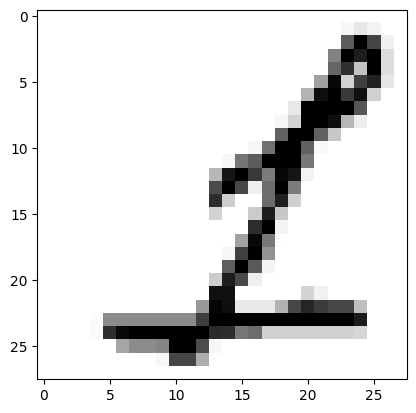

In [57]:
plt.show()
resized = cv2.resize(cell_copy, (28, 28), interpolation = cv2.INTER_AREA)
plotting = plt.imshow(resized,cmap='gray_r', )
plt.show()


In [55]:
import pickle

filename = '../models/k_neibors_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [58]:
resized = resized.reshape(784,) / 255
pred = loaded_model.predict([resized])

In [63]:
str(int(pred[0]))

'4'

In [92]:
import pickle

filename = '../models/forest_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
optimazed = resized.reshape(784,) / 255
pred = loaded_model.predict([optimazed])
pred

array([5.])

In [25]:
n = np.array([0., 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.62352941, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.2       , 0.55686275,
       1.        , 1.        , 0.66666667, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.30980392, 1.        , 1.        , 1.        , 1.        ,
       0.66666667, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.33333333, 0.90980392, 1.        ,
       1.        , 1.        , 1.        , 0.66666667, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.26666667,
       0.90980392, 1.        , 0.82352941, 0.55686275, 1.        ,
       0.90980392, 0.13333333, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.26666667, 1.        , 1.        , 0.22352941,
       0.04313725, 0.55686275, 1.        , 0.89019608, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.89019608,
       0.86666667, 0.6       , 0.13333333, 0.53333333, 1.        ,
       1.        , 0.57647059, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.4       , 0.95686275, 0.66666667, 0.        ,
       0.46666667, 1.        , 1.        , 0.6       , 0.04313725,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.66666667,
       0.90980392, 0.13333333, 0.44313725, 0.95686275, 1.        ,
       0.64313725, 0.06666667, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.66666667, 0.90980392, 0.2       ,
       0.64313725, 1.        , 0.77647059, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.4       , 0.4       ,
       0.8       , 1.        , 1.        , 1.        , 1.        ,
       0.46666667, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.46666667, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.53333333, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.26666667, 0.8       , 0.95686275, 0.82352941,
       0.2       , 0.73333333, 1.        , 1.        , 1.        ,
       0.84313725, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.26666667, 1.        ,
       1.        , 0.84313725, 0.        , 0.09019608, 0.73333333,
       0.97647059, 0.86666667, 1.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.17647059,
       0.4       , 0.93333333, 0.86666667, 0.6       , 0.13333333,
       0.09019608, 0.66666667, 1.        , 0.57647059, 0.33333333,
       1.        , 0.69019608, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.44313725, 1.        , 0.93333333,
       0.26666667, 0.        , 0.        , 0.69019608, 1.        ,
       1.        , 0.10980392, 0.33333333, 1.        , 0.22352941,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.17647059,
       0.89019608, 1.        , 0.26666667, 0.        , 0.        ,
       0.62352941, 1.        , 1.        , 0.46666667, 0.10980392,
       0.86666667, 1.        , 0.22352941, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.10980392, 0.82352941, 1.        , 0.55686275, 0.        ,
       0.        , 0.06666667, 0.64313725, 1.        , 0.95686275,
       0.44313725, 0.        , 0.10980392, 1.        , 1.        ,
       0.22352941, 0.        , 0.09019608, 0.73333333, 1.        ,
       0.93333333, 0.35686275, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.13333333, 0.73333333, 1.        ,
       1.        , 0.55686275, 0.        , 0.04313725, 0.6       ,
       1.        , 1.        , 0.46666667, 0.        , 0.        ,
       0.42352941, 1.        , 1.        , 0.53333333, 0.4       ,
       0.66666667, 1.        , 0.64313725, 0.4       , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.33333333, 1.        , 1.        , 0.86666667, 0.22352941,
       0.        , 0.57647059, 1.        , 1.        , 0.53333333,
       0.        , 0.        , 0.        , 0.89019608, 1.        ,
       1.        , 1.        , 1.        , 0.73333333, 0.4       ,
       0.04313725, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.09019608, 0.86666667, 1.        ,
       1.        , 0.15686275, 0.        , 0.53333333, 0.97647059,
       1.        , 0.55686275, 0.04313725, 0.        , 0.        ,
       0.        , 0.89019608, 1.        , 1.        , 1.        ,
       0.82352941, 0.10980392, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.10980392, 1.        , 0.44313725, 0.        , 0.37647059,
       1.        , 1.        , 0.97647059, 0.53333333, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.89019608,
       1.        , 1.        , 0.84313725, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.10980392, 1.        ,
       0.66666667, 0.4       , 1.        , 1.        , 0.73333333,
       0.53333333, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.26666667, 0.93333333, 1.        , 0.77647059,
       0.13333333, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10980392, 1.        , 1.        , 1.        ,
       1.        , 0.73333333, 0.13333333, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.66666667,
       1.        , 1.        , 0.44313725, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02352941,
       0.46666667, 1.        , 1.        , 0.82352941, 0.10980392,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.13333333, 0.90980392, 0.73333333,
       0.09019608, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

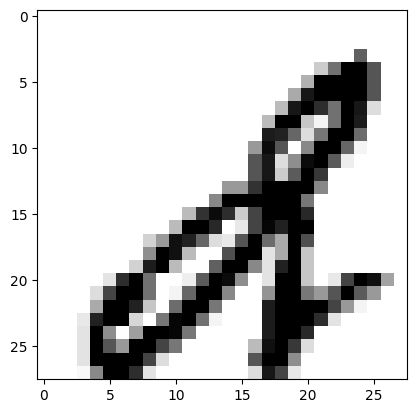

In [30]:
plotting = plt.imshow(n.reshape(28, 28),cmap='gray_r')
plt.show()

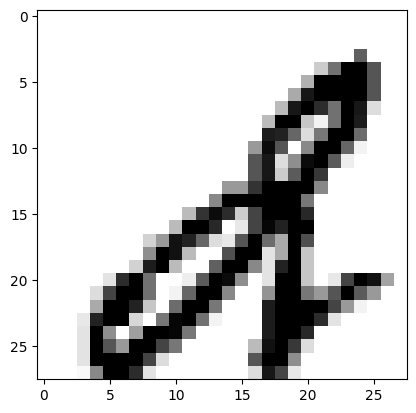

In [33]:
plotting = plt.imshow(n.reshape(28, 28),cmap='gray')
plt.show()

In [51]:
np.save('test', n)

In [6]:
data = np.load('../data/images.npy')

In [7]:
data.shape

(2, 784)

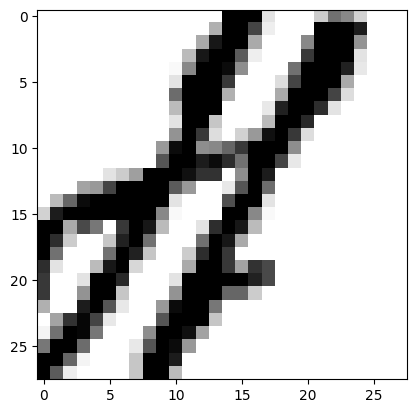

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
plotting = plt.imshow(data[1].reshape(28, 28),cmap='gray_r')
plt.show()
data

In [11]:
targets = np.load('../data/targets.npy')

In [14]:
targets[1]

-1.0

In [15]:
targets.shape

(2,)